In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import numpy as np
import matplotlib.pyplot as plt

from datasets import Dataset, Image
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

import evaluate

In [2]:
image_dir = "data/images"
image_files = sorted(glob(f"{image_dir}/*.jpg"))
image_files = sorted(list(filter(lambda x : not x.endswith('(1).jpg'), image_files)))

mask_dir = "data/masks"
mask_files = sorted(glob(f"{mask_dir}/*.tiff"))
mask_files = sorted(list(filter(lambda x : not x.endswith('(1).tiff'), mask_files)))

len(image_files), len(mask_files)

(102, 102)

In [17]:
original_ds = Dataset.from_dict({"pixel_values": image_files, "labels": mask_files})
original_ds = original_ds.cast_column("pixel_values", Image())
original_ds = original_ds.cast_column("labels", Image())
original_ds

Dataset({
    features: ['pixel_values', 'labels'],
    num_rows: 102
})

In [6]:
id2label = {0: "background", 1: "sandstone", 2: "mudstone"}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
print("Id2label:", id2label)

Id2label: {0: 'background', 1: 'sandstone', 2: 'mudstone'}


In [8]:
processor = SegformerImageProcessor(size={"width": 256, "height": 256})

def transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels, return_tensors="pt")
    return inputs

original_ds.set_transform(transforms)



In [9]:
metric = evaluate.load("mean_iou")

@torch.no_grad()
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  logits_tensor = torch.from_numpy(logits)
  # scale the logits to the size of the label
  logits_tensor = F.interpolate(
      logits_tensor,
      size=labels.shape[-2:],
      mode="bilinear",
      align_corners=False,
  ).argmax(dim=1)

  pred_labels = logits_tensor.detach().cpu().numpy()
  metrics = metric._compute(
          predictions=pred_labels,
          references=labels,
          num_labels=len(id2label),
          ignore_index=-1,
          reduce_labels=False,
      )
  # add per category metrics as individual key-value pairs
  per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
  per_category_iou = metrics.pop("per_category_iou").tolist()

  metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
  metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

  return metrics

In [11]:
model_path = r"assets\b2"

model = SegformerForSemanticSegmentation.from_pretrained(
    model_path,
    id2label=id2label,
    label2id=label2id
).eval()

### Inference Testing

In [ ]:
image = original_ds[5]['pixel_values']
gt_seg = original_ds[5]['labels']
image

(-0.5, 5999.5, 3999.5, -0.5)

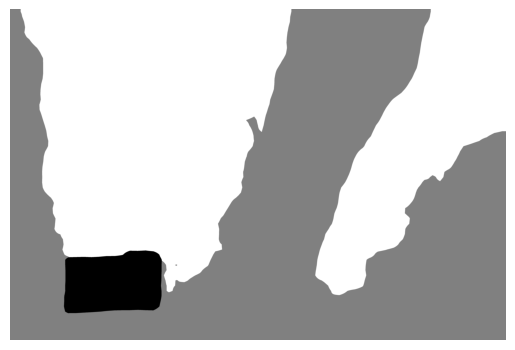

In [26]:
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = F.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]
plt.imshow(pred_seg, cmap="gray")
plt.axis("off")

In [28]:
pred_seg.numpy()

array([[1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int64)